# Obama vs Trump Image Classification

In this notebook, I download images of president Obama & Trump, and build a classifier to predict who is who. The code is based on fast.ai lectures.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import random

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

assert torch.cuda.is_available() & torch.backends.cudnn.enabled

PATH = "data/obama_trump_class/"
PATH_TRAIN = PATH+'train/'
DOWNLOAD_FLAG = True  # Select false if we have already donwloaded the images + labels

if not os.path.exists(PATH_TRAIN):
    os.makedirs(PATH_TRAIN)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Download Images

In [2]:
# Uncomment if running for the first time
#!git clone https://github.com/hardikvasa/google-images-download.git
#shutil.move("google-images-download/google_images_download", "img_downloader")
#shutil.rmtree("google-images-download")

In [3]:
if DOWNLOAD_FLAG:
    
    import download_img_list
    
    presidents = ['Barack Obama', 'Donald Trump']
    
    labels, err_list = download_img_list.download_img_list(presidents, PATH_TRAIN, 100)
    labels.to_csv(PATH+'labels.csv', index = False)
    
    print('\nPresidents that did not download: ')
    print(err_list)
else:
    labels = pd.read_csv(PATH+'labels.csv')


Processing element 0

Item no.: 1 --> Item name = Barack Obama
Evaluating...
Starting Download...
Completed Image ====> 1. president_barack_obama.jpg
Completed Image ====> 2. 5g0fc8xx_400x400.jpg
Completed Image ====> 3. barack-obama-12782369-1-402.jpg
Completed Image ====> 4. 44_barack_obama1.jpg
Completed Image ====> 5. barack-obama.jpeg
Completed Image ====> 6. 886536868.jpg
Completed Image ====> 7. lead_720_405.jpg
Completed Image ====> 8. 104723838-gettyimages-850288240.1910x1000.jpg
Completed Image ====> 9. image?url=https%3a%2f%2fpeopledotcom.files.wordpress.com%2f2017%2f11%2fbarack-obama1.jpg%3fw%3d2000&w=700&q=85.jpg
Completed Image ====> 10. 170px-barackobamaportrait.jpg
Completed Image ====> 11. _102570197_gettyimages-1000226010.jpg
Completed Image ====> 12. barack-obama---americas-first-african-american-president.jpg
Completed Image ====> 13. gty_barack_obama_1_jt_160803_16x9_1600.jpg
Completed Image ====> 14. 090118-john-mccain-funeral-obama-kal-1080x608.jpg
Completed Ima

Completed Image ====> 22. ct-donald-trump-michael-cohen-trouble-20180410.jpg
Completed Image ====> 23. donald-trump-2.jpg
Completed Image ====> 24. 1920.jpg
Completed Image ====> 25. trump-james.jpg
Completed Image ====> 26. 1a2c6c72d596063a3de01d6ce19bd3f1.jpg
Completed Image ====> 27. time-100-donald-trump2.jpg
Completed Image ====> 28. ap_18074548208216.jpg
Completed Image ====> 29. kuuht00m_400x400.jpg
Completed Image ====> 30. 220px-vladimir_putin_and_donald_trump_at_the_2017_g-20_hamburg_summit_%284%29.jpg
Completed Image ====> 31. ap_881833377124.jpg
Completed Image ====> 32. gettyimages-860989406.jpg
Completed Image ====> 33. donald_trump_photo_michael_stewartwireimage_gettyimages_169093538_croppedjpg
Completed Image ====> 34. telemmglpict000144661011_trans_nvbqzqnjv4bqqdfo_li8bnurdrcvfsgxutufihelwdj7eo4ajfswkvw.jpeg
URLError on an image...trying next one... Error: <urlopen error [Errno -3] Temporary failure in name resolution>
Completed Image ====> 35. donald-trump-1-ap-jt-180

In [4]:
labels.groupby('label').size().sort_values().head(10)  # In case there are classes with few exmaples

label
Barack_Obama    93
Donald_Trump    97
dtype: int64

## Look at the downloaded Images

In [5]:
def showPresident(name, labels = labels, dims = (2, 5), directory = PATH_TRAIN):
    '''Show images of a given president'''
    nrows, ncols = dims
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize =(ncols * 5, nrows * 5))
    fns = list(labels['id'][labels['label'] == name])
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            axes[i, j].imshow(plt.imread(directory+fns[k]), cmap = 'gray')
            k = (k + 1) % (len(fns))

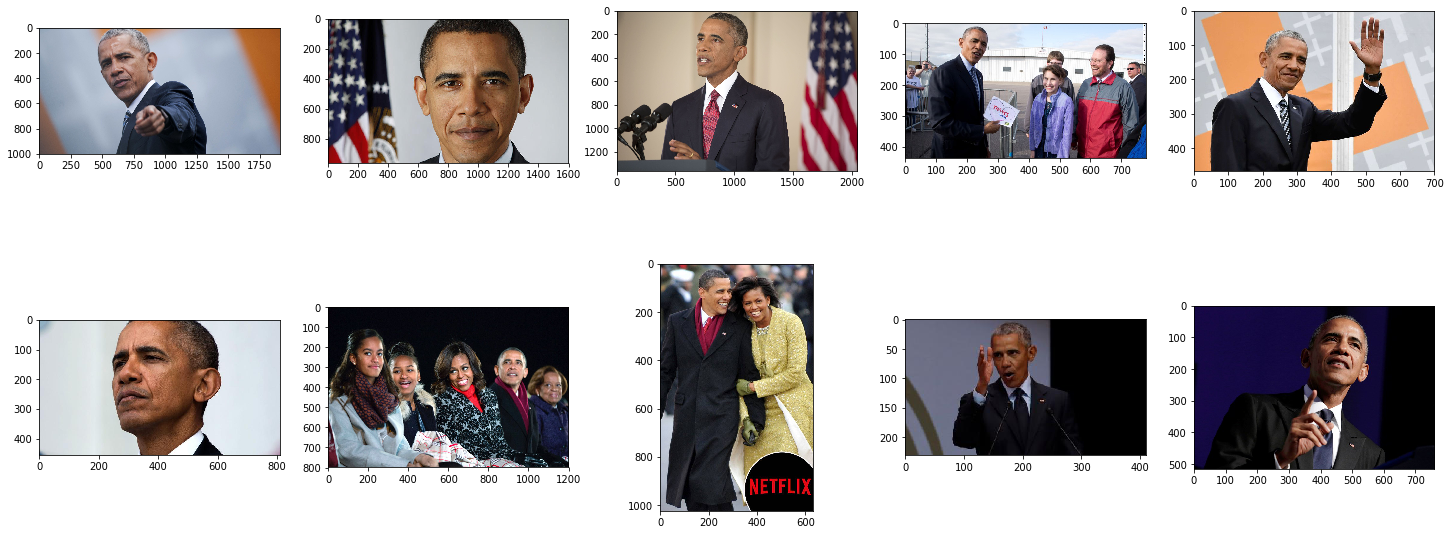

In [6]:
showPresident("Barack_Obama")

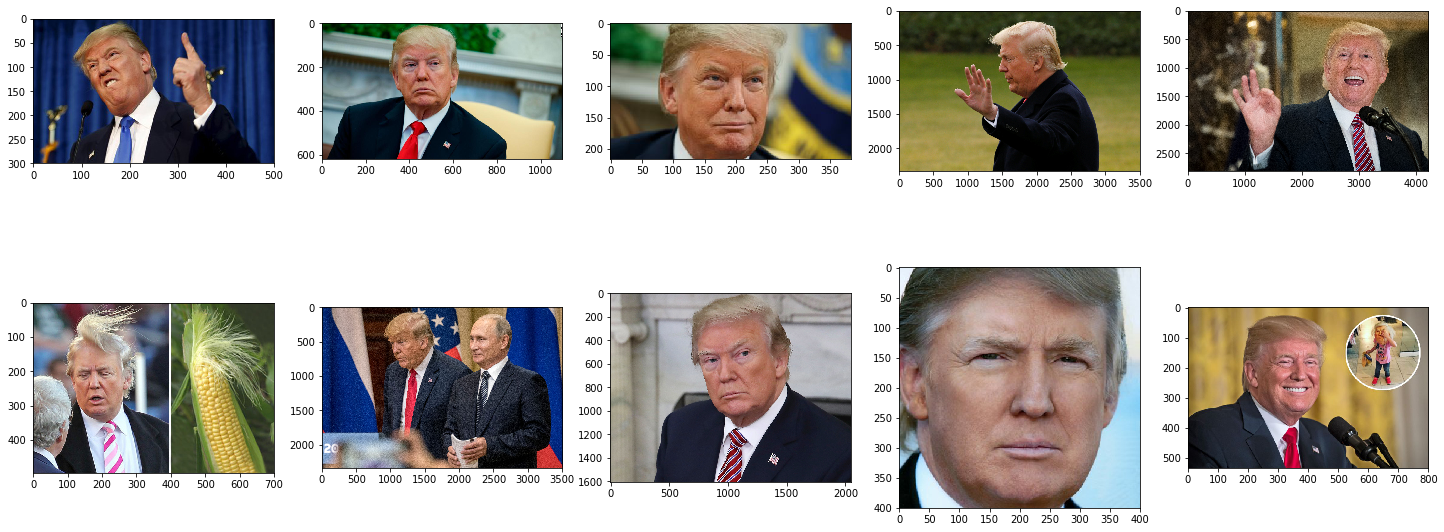

In [7]:
showPresident("Donald_Trump")

## Fit Model

Since I only have ~200 training examples, I don't run lr_find (as even with bs = 32, there are only ~7 minibatches).

In [8]:
sz = 128  # Let's start with small sizes
bs = 32
arch = resnet34
val_idxs = get_cv_idxs(len(labels.index), seed = 42)
data = ImageClassifierData.from_csv(PATH, 'train/', PATH+'labels.csv', bs = bs, 
                                    tfms = tfms_from_model(arch, sz), val_idxs = val_idxs)
learn = ConvLearner.pretrained(arch, data, precompute = True)

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


In [9]:
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                
    0      0.84186    0.595176   0.605263  
    1      0.682597   0.463731   0.763158        
    2      0.573682   0.348684   0.842105        



[array([0.34868]), 0.8421052600208082]

The training loss is higher than the validation loss, so let's keep on training.

In [10]:
learn.fit(0.01, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy        
    0      0.302631   0.332077   0.842105  
    1      0.319345   0.317763   0.815789        
    2      0.305104   0.318366   0.815789        



[array([0.31837]), 0.8157894736842105]

In [11]:
learn.save('Obama_Trumpv1')

## Looking at the Results

In [12]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds)
y = data.val_y

In [13]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_correct(cat, is_correct = True, num = 4): 
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == cat)
    idxs = np.where(mask, )[0]
    mult = -1 if is_correct else 1
    return idxs[np.argsort(mult*probs[:, cat][idxs])[:num]]

def plot_val_with_title(cat, is_correct = True, title = '', num = 4):
    idxs = most_by_correct(cat, is_correct, num)
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[:, cat][x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Most Correct Obama Pics


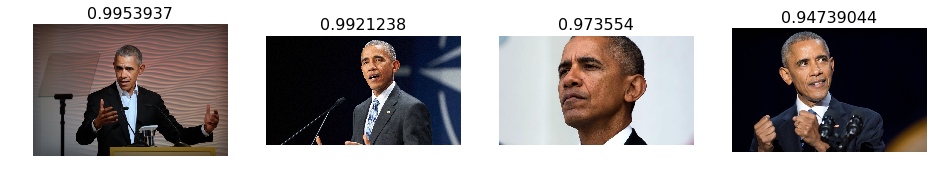

In [14]:
plot_val_with_title(0, True, 'Most Correct Obama Pics')

Most Incorrect Obama Pics


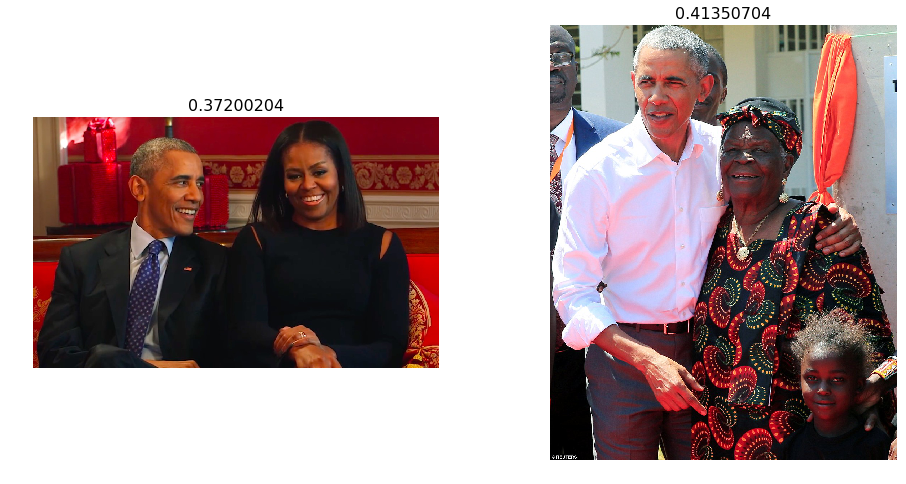

In [15]:
plot_val_with_title(0, False, 'Most Incorrect Obama Pics')

Most Correct Trump Pics


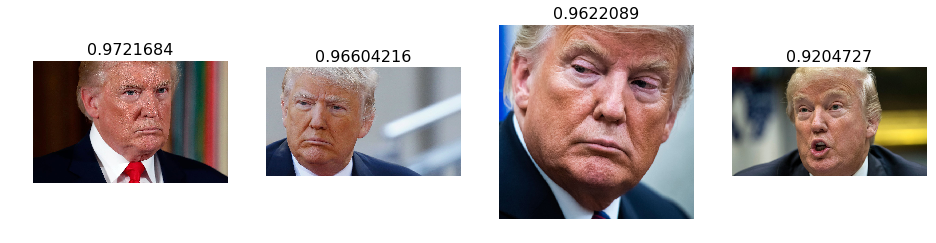

In [16]:
plot_val_with_title(1, True, 'Most Correct Trump Pics')

Most Incorrect Trump Pics


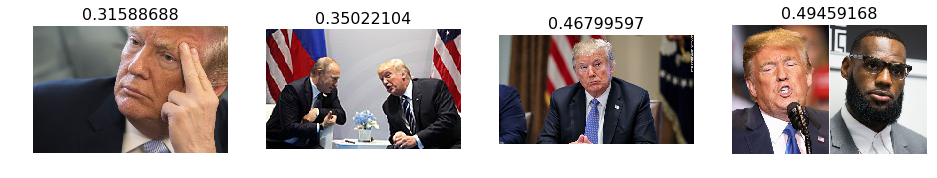

In [17]:
plot_val_with_title(1, False, 'Most Incorrect Trump Pics')

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

cm

array([[16,  2],
       [ 5, 15]])

## Add data augmentations, set size to 299

In [19]:
learn.load('Obama_Trumpv1')

In [20]:
sz = 229

In [21]:
tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.15)

In [22]:
data = ImageClassifierData.from_csv(PATH, 'train/', PATH + 'labels.csv', bs, tfms, val_idxs=val_idxs)

In [23]:
learn.set_data(data, precompute = False)

In [24]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy        
    0      0.196065   0.314489   0.868421  
    1      0.20454    0.31302    0.815789        



[array([0.31302]), 0.8157894736842105]

In [25]:
learn.save('Obama_Trumpv2')

## Unfreeze layers

In [26]:
learn.load('Obama_Trumpv2')

In [27]:
lr = 0.01
lrs = [lr, lr/5, lr/25]

In [28]:
learn.unfreeze()

In [29]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                
    0      0.490942   0.531532   0.789474  
    1      0.490526   0.471845   0.815789                
    2      0.488027   0.435455   0.815789                
    3      0.492088   0.427004   0.815789                
    4      0.498818   0.421073   0.815789                
    5      0.511361   0.410192   0.815789                
    6      0.502442   0.411061   0.815789                



[array([0.41106]), 0.8157894736842105]

In [30]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds)
y = data.val_y

cm = confusion_matrix(y, preds)

cm

array([[14,  4],
       [ 3, 17]])

In [31]:
log_preds, y = learn.TTA()

In [32]:
probs = np.mean(np.exp(log_preds),0)

In [33]:
preds = np.argmax(probs, axis = 1)

cm = confusion_matrix(y, preds)

cm

array([[15,  3],
       [ 2, 18]])

Most Incorrect Obama Pics


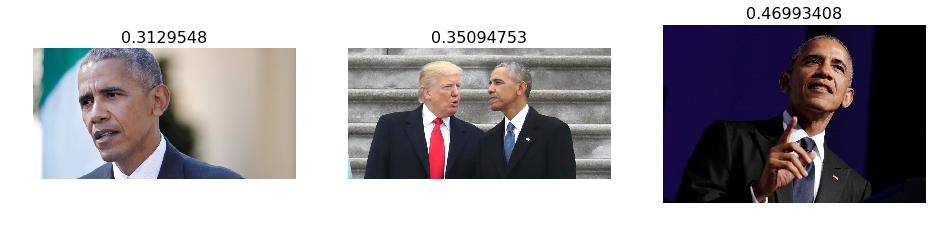

In [34]:
plot_val_with_title(0, False, 'Most Incorrect Obama Pics')

Most Incorrect Trump Pics


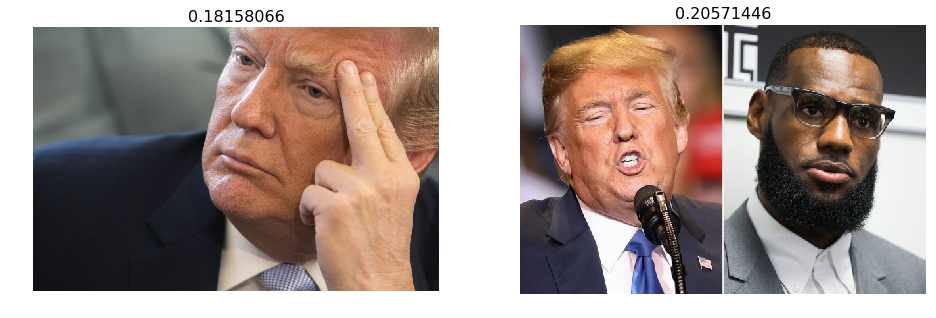

In [35]:
plot_val_with_title(1, False, 'Most Incorrect Trump Pics')

In [36]:
learn.save('Obama_Trumpv3')

If we don't count the misclassified images with two people in them, we have 3 misclassifications out of 38 validation set images.